In [1]:
# importing necessary modules

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from numpy import load
import joblib

from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category = DeprecationWarning)


In [2]:
dict_data = load(os.path.join(os.path.abspath('..'), 'data', 'data_x.npz'))
X = dict_data['arr_0']
dict_data = load(os.path.join(os.path.abspath('..'), 'data', 'data_y.npz'))
Y = dict_data['arr_0']

In [3]:
X.shape, Y.shape

((600, 106, 160), (600,))

In [4]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1, 1)).toarray()

print(Y.shape)
Y[:5]

(600, 6)


array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]])

In [5]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, random_state=125, test_size=0.25, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((450, 106, 160), (450, 6), (150, 106, 160), (150, 6))

In [6]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((450, 106, 160, 1), (450, 6), (150, 106, 160, 1), (150, 6))

In [7]:
epochs = 100
model_store_path = os.path.join(os.path.abspath('..'), 'data', 'lstm.pkl')
history = joblib.load(model_store_path)
model = history.model

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-02-15 14:39:28         3952
metadata.json                                  2023-02-15 14:39:28           64
variables.h5                                   2023-02-15 14:39:28     42348376
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\conv2d
......vars
.........0
.........1
...layers\conv2d_1
......vars
.........0
.........1
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...layers\dropout
......vars
...layers\dropout_1
......vars
...layers\dropout_2
......vars
...layers\flatten
......vars
...layers\max_pooling2d
......vars
...layers\max_pooling2d_1
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
...

5/5 [==============================] - 1s 54ms/step - loss: 0.4877 - accuracy: 0.8600
Accuracy of our model on test data :  86.00000143051147 %


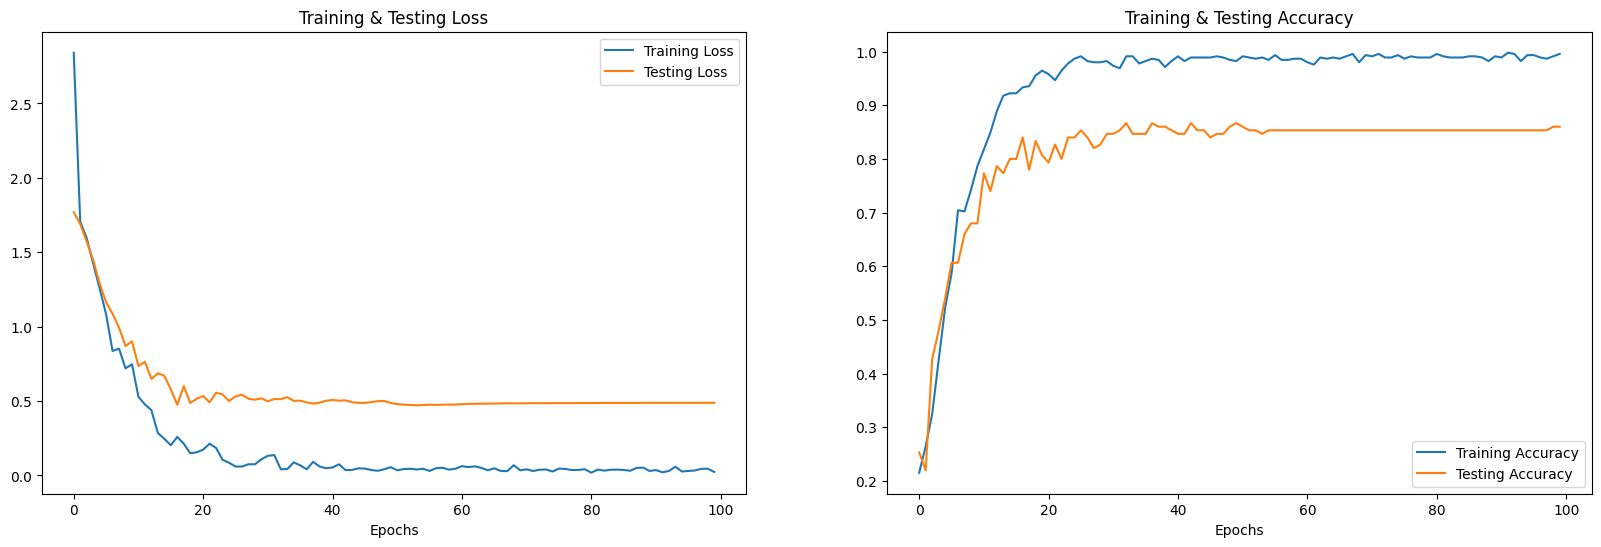

In [8]:
print("Accuracy of our model on test data : ",
      model.evaluate(x_test, y_test)[1]*100, "%")

epochs = [i for i in range(epochs)]
fig, ax = plt.subplots(1, 2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20, 6)
ax[0].plot(epochs, train_loss, label='Training Loss')
ax[0].plot(epochs, test_loss, label='Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")
plt.grid(axis='y')

ax[1].plot(epochs, train_acc, label='Training Accuracy')
ax[1].plot(epochs, test_acc, label='Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.grid(axis='y')
plt.show()


In [9]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)


5/5 [==============================] - 0s 48ms/step


In [10]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,neutral,sad
1,angry,angry
2,neutral,sad
3,fear,sad
4,happy,happy
5,sad,happy
6,sad,sad
7,neutral,neutral
8,sad,sad
9,sad,sad


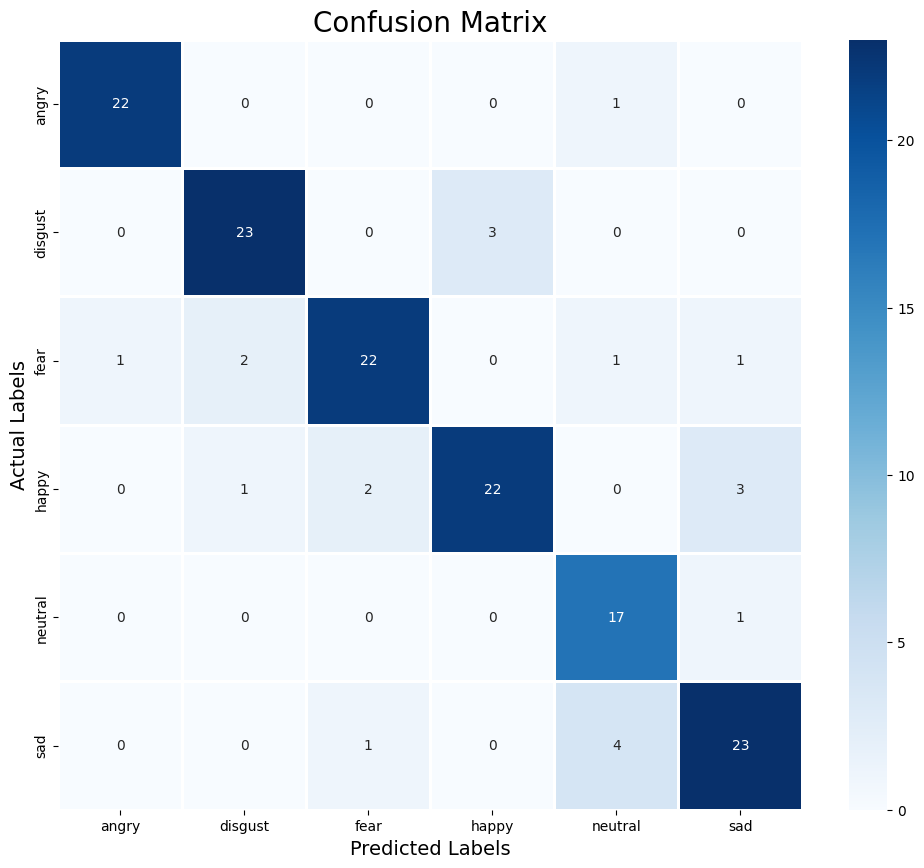

In [11]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
cm = pd.DataFrame(cm, index=[i for i in encoder.categories_], columns=[
                  i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues',
            linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [12]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.96      0.96      0.96        23
     disgust       0.88      0.88      0.88        26
        fear       0.88      0.81      0.85        27
       happy       0.88      0.79      0.83        28
     neutral       0.74      0.94      0.83        18
         sad       0.82      0.82      0.82        28

    accuracy                           0.86       150
   macro avg       0.86      0.87      0.86       150
weighted avg       0.86      0.86      0.86       150

